In [8]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [9]:
def trajectory_conversion(trajectory):
    input_trajectory = torch.zeros(len(trajectory), 3)
    for i in range(1, trajectory.size()[0]):
        del_x = trajectory[i][0]-trajectory[i-1][0]
        del_y = trajectory[i][1]-trajectory[i-1][1]
        del_z = trajectory[i][2]-trajectory[i-1][2]
        
        input_trajectory[i][0] = del_x
        input_trajectory[i][1] = del_y
        input_trajectory[i][2] = del_z
        
    return input_trajectory  

In [10]:
def create_inout_sequences(input_data, tw=100):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw].to(device)
        train_label = input_data[i+tw].to(device)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=128, output_size=3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, device=device),
                            torch.zeros(1,1,self.hidden_layer_size, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out = F.relu(lstm_out.view(len(input_seq), -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [12]:
def train_model(net, train_inout_seq, lr=0.001, epochs=20, device=device):
    model = net.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()
    model.train()
    #print(model)
    for i in range(epochs):
        #optimizer.zero_grad()
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device), 
                                 torch.zeros(1, 1, model.hidden_layer_size, device=device))
            pred = model(seq)
            single_loss = loss_function(pred, labels)
            single_loss.backward()
            optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    return model

In [13]:
def getTrain_TestTensor(filename):
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    df = df.drop(columns=['#date', 'ssh[m]', 'average_ssh[m]', 'geoid_height[m]', 'tide_height[cm]'])
    df['timestamp'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)
    df['relative_timestamp'] = df['timestamp']-df['timestamp'][0]
    df = df.drop(columns=['time', 'timestamp'])
    tl = int(len(df)*0.68)
    print(tl)
    testSize = int(len(df)) - tl
    print(testSize)
    
    trainTensor = torch.zeros(tl, 3).to(device)
    trainTensor[0][0] = df['latitude'][0]
    trainTensor[0][1] = df['longitude'][0]
    trainTensor[0][2] = df['flight_altitude[m]'][0]
    print(trainTensor.shape)
    
    j = 0
    for i in range(1, tl):
        if(df['relative_timestamp'][i]!=df['relative_timestamp'][i-1]):
            j+=1
            trainTensor[j][0] = df['latitude'][i]
            trainTensor[j][1] = df['longitude'][i]
            trainTensor[j][2] = df['flight_altitude[m]'][i]
    trainTensor = trainTensor[trainTensor.abs().sum(dim=1) != 0]
    testTensor = torch.zeros(testSize, 3).to(device)
    testTensor[0][0] = df['latitude'][tl]
    testTensor[0][1] = df['longitude'][tl]
    testTensor[0][2] = df['flight_altitude[m]'][tl]
    j = 0
    for i in range(tl, len(df)):
        if(df['relative_timestamp'][i]!=df['relative_timestamp'][i-1]):
            j+=1
            testTensor[j][0] = df['latitude'][i]
            testTensor[j][1] = df['longitude'][i]
            testTensor[j][2] = df['flight_altitude[m]'][i]
    testTensor = testTensor[testTensor.abs().sum(dim=1) != 0]
    print(len(trainTensor), end = ' ')
    print(len(testTensor))
    return [trainTensor, testTensor]

In [7]:
file1 = 'flight20161208-1.csv'
trainTensor, testTensor = getTrain_TestTensor(file1)
train_window = 50
testSize = len(testTensor)
conv_tT = trajectory_conversion(trainTensor)
train_inout_seq = create_inout_sequences(conv_tT, train_window)
net = LSTM()
tm = train_model(net, train_inout_seq, epochs=15)
torch.save(tm.state_dict(), 'trained_model.pth')

9817
4621
torch.Size([9817, 3])
786 370


KeyboardInterrupt: 

In [8]:
file2 = 'flight20161208-2.csv'
trainTensor, testTensor = getTrain_TestTensor(file1)
train_window = 50
testSize = len(testTensor)
conv_tT = trajectory_conversion(trainTensor)
train_inout_seq = create_inout_sequences(conv_tT, train_window)
net = LSTM()
net.load_state_dict(torch.load('trained_model.pth'))
tm = train_model(net, train_inout_seq, epochs=15)
torch.save(tm.state_dict(), 'trained_model.pth')

9817
4621
torch.Size([9817, 3])
786 370
epoch:  14 loss: 0.00005112


In [ ]:
file3 = 'flight20161208-3.csv'
trainTensor, testTensor = getTrain_TestTensor(file1)
train_window = 50
testSize = len(testTensor)
conv_tT = trajectory_conversion(trainTensor)
train_inout_seq = create_inout_sequences(conv_tT, train_window)
net = LSTM()
net.load_state_dict(torch.load('trained_model.pth'))
tm = train_model(net, train_inout_seq, epochs=15)
torch.save(tm.state_dict(), 'trained_model.pth')

In [10]:
file4 = 'flight20161208-4.csv'
trainTensor, testTensor = getTrain_TestTensor(file1)
train_window = 50
testSize = len(testTensor)
conv_tT = trajectory_conversion(trainTensor)
train_inout_seq = create_inout_sequences(conv_tT, train_window)
net = LSTM()
net.load_state_dict(torch.load('trained_model.pth'))
tm = train_model(net, train_inout_seq, epochs=15)
torch.save(tm.state_dict(), 'trained_model.pth')

9817
4621
torch.Size([9817, 3])
786 370
epoch:  14 loss: 0.00008444


In [11]:
file7 = 'flight20161208-7.csv'
trainTensor, testTensor = getTrain_TestTensor(file1)
train_window = 50
testSize = len(testTensor)
conv_tT = trajectory_conversion(trainTensor)
train_inout_seq = create_inout_sequences(conv_tT, train_window)
net = LSTM()
net.load_state_dict(torch.load('trained_model.pth'))
tm = train_model(net, train_inout_seq, epochs=15)
torch.save(tm.state_dict(), 'trained_model.pth')

9817
4621
torch.Size([9817, 3])
786 370
epoch:  14 loss: 0.00000729


In [14]:
def predict_30(model, conv_tT, trainTensor, fut_pred=30, device=device):
    test_inputs = conv_tT[-train_window:]
    model.eval()
    for i in range(fut_pred):
        seq = test_inputs[-train_window:].to(device)
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=device), 
                            torch.zeros(1, 1, model.hidden_layer_size, device=device))
            Pred = model(seq)
            newObservation = torch.tensor([[Pred[0], Pred[1], Pred[2]]])      
            torch.cat((test_inputs, newObservation))
    X = []
    Y = []
    Z = []
    trainTensor[-1][0].item()
    trainTensor[-1][1].item()
    for x, y, z in test_inputs[-fut_pred:]:
        X.append(x)
        Y.append(y)
        Z.append(z)
        #print(x, y, z)
    X = np.asarray(X)
    Y = np.asarray(Y)
    Z = np.asarray(Z)
    X = np.cumsum(X)
    Y = np.cumsum(Y)
    Z = np.cumsum(Z)
    X_f = X+trainTensor[-1][0].item()
    Y_f = Y+trainTensor[-1][1].item()
    Z_f = Z+trainTensor[-1][2].item()
    #plt.plot(X_f, Y_f)
    #plt.show()
    #print(X_f)
    #print(Y_f)
    predicted = torch.zeros(fut_pred, 3).to(device)
    for i in range(fut_pred):
        predicted[i][0] = X_f[i].item()
        predicted[i][1] = Y_f[i].item()
        predicted[i][2] = Z_f[i].item()
    return [predicted, X_f, Y_f, Z_f]

In [15]:
def Completed_trajectory(model, conv_tT, trainTensor, fut_pred, testTensor, plot=True, device=device, merge=False):
    X_f = np.asarray([])
    Y_f = np.asarray([])
    Z_f = np.asarray([])
    predicted_tensor = torch.zeros(1, 3).to(device)
    predicted_tensor[0] = trainTensor[-1]
    temp = trainTensor[:]
    for i in range(int(fut_pred/30)):
        pred = predict_30(model, conv_tT, temp, 30, device)
        temp = torch.cat((temp, pred[0]))
        predicted_tensor = torch.cat((predicted_tensor, pred[0]))
        X_f = np.concatenate((X_f, pred[1]), axis=0)
        Y_f = np.concatenate((Y_f, pred[2]), axis=0)
        Z_f = np.concatenate((Z_f, pred[3]), axis=0)
    if fut_pred%30!=0:
        pred = predict_30(model, conv_tT, temp, int(fut_pred%30), device)
        temp = torch.cat((temp, pred[0]))
        predicted_tensor = torch.cat((predicted_tensor, pred[0]))
        X_f = np.concatenate((X_f, pred[1]), axis=0)
        Y_f = np.concatenate((Y_f, pred[2]), axis=0)
        Z_f = np.concatenate((Z_f, pred[3]), axis=0)
    
    if plot:
        plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
        plt.plot(testTensor[:, :1].cpu(), testTensor[:, 2:].cpu(), label='test')
        plt.xlabel('latitude')
        plt.ylabel('altitude')
        plt.legend()
        plt.show()

        plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
        plt.plot(X_f, Z_f, label='predicted')
        plt.xlabel('latitude')
        plt.ylabel('altitude')
        plt.legend()
        plt.show()

        plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
        plt.plot(testTensor[:, :1].cpu(), testTensor[:, 2:].cpu(), label='test')
        plt.plot(X_f, Z_f, label='predicted')
        plt.xlabel('latitude')
        plt.ylabel('altitude')
        plt.legend()
        plt.show()
        plt.grid(color='white', linewidth=2)
        plt.savefig('output/output', dpi = 500)
    if(merge):
        return temp
    return predicted_tensor[1:]

In [16]:
prediction = Completed_trajectory(tm, conv_tT, trainTensor, 50, testTensor, device=device)

NameError: name 'tm' is not defined

320


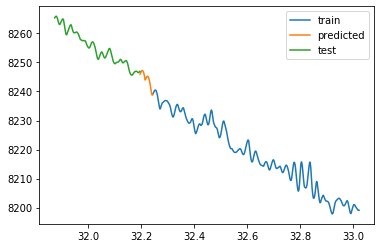

In [16]:
testPlot = testTensor.cpu()
print(testSize - len(prediction))
testPlot = testPlot[-(len(testTensor) - len(prediction)):]
plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
plt.plot(prediction[:, :1].cpu(), prediction[:, 2:].cpu(), label='predicted')
plt.plot(testPlot[:, :1].cpu(), testPlot[:, 2:], label='test')
plt.legend()
plt.show()